# Visualisation

We will generate node embeddings, reduce their dimensions, and finally visualsie these embeddings: we expect to empirically observe that the embeddings become more and more similar with more layers.

We will use the **validation dataset** for the visualisation.

In [2]:
OUTPUT_DIR = './visuals/'

In [3]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%run datasets.ipynb

In [41]:
def dimension_reduction(model: nn.Module, dataset_name: str) -> pd.DataFrame:
    """
    Takes a model object and data, performs T-SNE, and returns a [DataFrame] containing 
    reduced variables and labels for each data point.
    
    Args:
    - model: model object for generating features
    - dataset_name: name of the dataset
    Returns:
    - pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2',
                    and 'labels' as a column
     """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data = load_data(dataset_name, data_only=True)

    model.eval()
    x = data.x.to(device)  # node features
    edge_index = data.edge_index.to(device)  # graph structure

    # get node embeddings
    with torch.no_grad():  # disable gradient calculation
        node_embeddings = model.generate_node_embeddings(x, edge_index) # (X, A)

    # dim-reduction of node embeddings with T-SNE (to 2D)
    tsne = TSNE(n_components=2, random_state=77887) 
    # need to copy Tensor to host memory first with .cpu().numpy()
    reduced_embeddings = tsne.fit_transform(node_embeddings.cpu().numpy())

    # format result df
    reduced_df = pd.DataFrame(reduced_embeddings,
                              columns=['dimension 1', 'dimension 2'])
    reduced_df['labels'] = data.y.cpu().numpy()  # target labels

    return reduced_df

### Visualisation with scatter plots

In [42]:
VIS_LAYERS = range(2,21,6)

In [43]:
def visualise_one(n, df, model_name, dataset_name) -> None:
    """Visualises node embeddings as a scatter plot for one model."""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(df['dimension 1'], df['dimension 2'], c=df['labels'],
                         cmap='tab10', s=10)
    plt.colorbar(scatter, ax=ax, label='class')  # color bar for classes
    
    ax.set_title(f"Visualisation of node embeddings from {model_name}",
                 fontsize=16)
    ax.set_xlabel("dimension 1", fontsize=14)
    ax.set_ylabel("dimension 2", fontsize=14)

    # show the plot
    plt.show()
    fig.savefig(OUTPUT_DIR + f'{dataset_name}/{model_name}/{n}_layer_vis.jpg', bbox_inches='tight')

In [44]:
def visualise_embeddings(models, model_name, dataset_name, 
                         layers=VIS_LAYERS):
    """
    Visualises dimensionality-reduced node embeddings generated by the given models.
    - models: dictionary of (number of layers : trained model) pairs
    - params: training parameters
    """
    feature_dict = { n: dimension_reduction(models[n], dataset_name) for n in layers }
    for n, df in feature_dict.items():
        visualise_one(n, df, model_name, dataset_name)

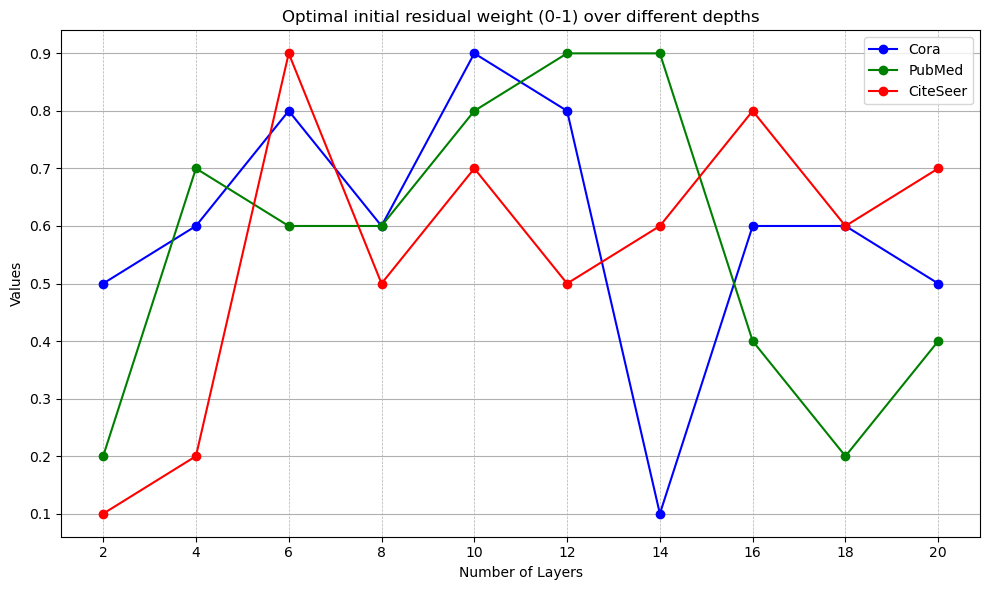

In [6]:
import matplotlib.pyplot as plt

# Data
layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
cora = [0.5, 0.6, 0.8, 0.6, 0.9, 0.8, 0.1, 0.6, 0.6, 0.5]
pubmed = [0.2, 0.7, 0.6, 0.6, 0.8, 0.9, 0.9, 0.4, 0.2, 0.4]
citeseer = [0.1, 0.2, 0.9, 0.5, 0.7, 0.5, 0.6, 0.8, 0.6, 0.7]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(layers, cora, label="Cora", marker='o', linestyle='-', color='b')
plt.plot(layers, pubmed, label="PubMed", marker='o', linestyle='-', color='g')
plt.plot(layers, citeseer, label="CiteSeer", marker='o', linestyle='-', color='r')

# Adding labels and title
plt.xlabel("Number of Layers")
plt.ylabel("Values")
plt.title("Optimal initial residual weight (0-1) over different depths")
plt.xticks(layers)  # Set the x-ticks to match the layer values
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
